Author: Ahmed Youri Sobhi [ahmedyousrisobhi@gmail.com]

Creation_date: 8th Sep 2023

Notebook number : 4

Objective: Dataset Modeling.

# Importing Required Libararies and Packages

In [55]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np

# Used for visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.cluster import KMeans, AgglomerativeClustering

import sys
sys.path.append('../src/tools/')

import pipelinetransformers

# To save the model locally
import joblib

# Data Loading

In [56]:
df = (
    pd.read_csv('../data/raw/marketing_campaign.csv', sep='\t')
    .assign(
        Dt_Customer= lambda x:pd.to_datetime(x.Dt_Customer, format='%d-%m-%Y')
    )
)

# Display first 5 rows
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


# Train Test Split

In [57]:
# Split the data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

df_train.shape, df_test.shape

((2016, 29), (224, 29))

# Create Preprocessing Pipeline


In [58]:
# Define the preprocessing steps for the entire dataset
data_preprocessing = Pipeline(
    [
        ('data_cleaning', pipelinetransformers.preprocessTransformer()),  # Custom data cleaning step
        ('feature_engineering', pipelinetransformers.featureEngTransformer()),  # Custom feature engineering step
    ]
)

numeric_transformer = Pipeline(
    [
        ('skewness', pipelinetransformers.SkewnessTransformer()),
        ('impute', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohc', OneHotEncoder(handle_unknown='ignore'))
    ]
)

"""
By setting remainder='passthrough', you ensure that all columns in the input are included in the output without specifying them by name. 
This should allow you to use the pipeline with data that might not have column names and resolve the "Specifying the columns using strings" error.
"""

data_preprocessing.set_output(transform='pandas')

scalling_transformer = ColumnTransformer(
    [
        ('numericals', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('Categorical', categorical_transformer, make_column_selector(dtype_include='object'))
    ],
    remainder='drop',
    n_jobs=-1
)

model_preprocessor = Pipeline(
    steps=[
        ('data_preprocess', data_preprocessing),
        ('update_feature_lists', pipelinetransformers.updateFeaturesList()),
        ('scaller', scalling_transformer)
    ]
)

In [59]:
# # Testing
model_preprocessor.fit(df_train)

{'No Fix': [0, 2, 3, 4, 5, 6, 7, 10, 13, 14, 16], 'yeojohnson': [8], 'sqrt': [9]}


Pipeline(steps=[('data_preprocess',
                 Pipeline(steps=[('data_cleaning', preprocessTransformer()),
                                 ('feature_engineering',
                                  featureEngTransformer())])),
                ('update_feature_lists', updateFeaturesList()),
                ('scaller',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numericals',
                                                  Pipeline(steps=[('skewness',
                                                                   SkewnessTransformer()),
                                                                  ('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd610>),
                                                 ('Categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd760>)]))])

In [60]:
model_preprocessor.transform(df_train)

array([[ 0.57624122, -0.71809676,  0.04905392, ...,  1.        ,
         0.        ,  1.        ],
       [-0.16635918,  0.18569544, -0.86344677, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.67789173, -1.6566502 ,  2.94162146, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.59552195,  0.63759154,  1.54006811, ...,  0.        ,
         0.        ,  1.        ],
       [-0.12362996, -0.96142543, -0.73521955, ...,  0.        ,
         1.        ,  0.        ],
       [-1.12428058,  0.7766365 , -0.85151866, ...,  0.        ,
         0.        ,  1.        ]])

## Dimensionality Reduction
In our dataset, the current features are large, and still we have some highly correlated features after manually removing them, So in the next step we will use PCA "Principal Component Analysis" for dimensionality reduction.

Dataset shape:  (1994, 26)


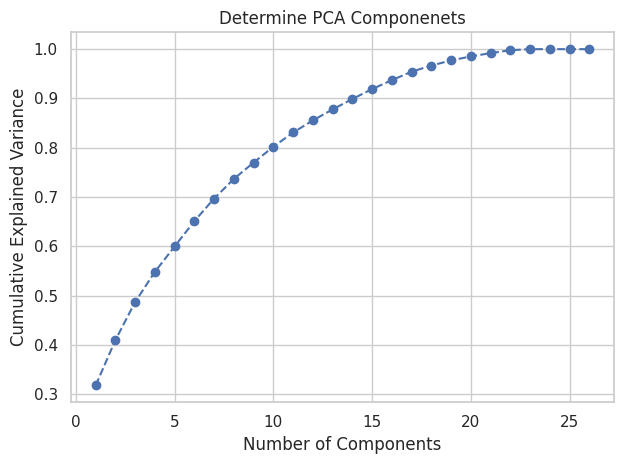

In [61]:
# Choosing the number of components
df_train_with_features = model_preprocessor.transform(df_train)

print("Dataset shape: ", df_train_with_features.shape)

pca = PCA()

pca.fit(df_train_with_features)  # Fit PCA to your data

explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Determine PCA Componenets')
plt.tight_layout()
plt.savefig('../report/plots/Determine PCA Componenets.jpg')
plt.show()

In [74]:
n_components = 10
pca_pipeline = Pipeline(
    steps=[
        ('model_preprocessor', model_preprocessor),
        ('PCA', PCA(n_components=n_components))
    ]
)

In [75]:
# # Testing
pca_pipeline.fit(df_train)

# pca_pipeline.transform(df_train)

{'No Fix': [0, 2, 3, 4, 5, 6, 7, 10, 13, 14, 16], 'yeojohnson': [8], 'sqrt': [9]}


Pipeline(steps=[('model_preprocessor',
                 Pipeline(steps=[('data_preprocess',
                                  Pipeline(steps=[('data_cleaning',
                                                   preprocessTransformer()),
                                                  ('feature_engineering',
                                                   featureEngTransformer())])),
                                 ('update_feature_lists', updateFeaturesList()),
                                 ('scaller',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('numericals',
                                                                   Pipeline(steps=[('skewness',
                                                                                    SkewnessTransformer()),
                                                                                   ('im...
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd610>),
                                                                  ('Categorical',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohc',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd760>)]))])),
                ('PCA', PCA(n_components=10))])

In [76]:
# Caluclate the Explained Variance

# Access the PCA step in the pipeline
pca_step = pca_pipeline.named_steps['PCA']

# Get the explained variance ratio
explained_variance_ratio = pca_step.explained_variance_ratio_

# Analysis the explained variance ratio
print(explained_variance_ratio)

[0.31753909 0.09210124 0.07732212 0.0611337  0.05165981 0.05132997
 0.04581013 0.03981332 0.03320168 0.03209691]


Variance Explained by Each Component: Each value in the explained_variance_ratio_ array represents the proportion of variance explained by one of the six principal components. For example:
- The first principal component (PC1) explains approximately 30.19% of the total variance.
- The second principal component (PC2) explains approximately 10.89% of the total variance.
- The third principal component (PC3) explains approximately 8.25% of the total variance.
- And so on for the remaining components.

## Determining the number of clusters

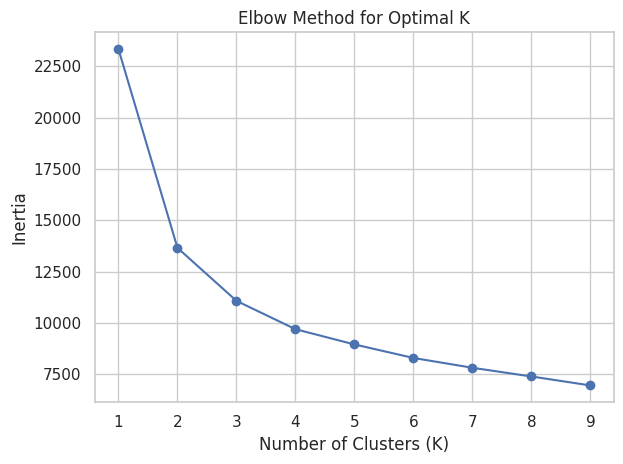

In [65]:
df_pca = pca_pipeline.transform(df_train)

inertias = []
K_range = range(1, 10)  # Try different values of K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)  # X_pca is your PCA-transformed data
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.tight_layout()
plt.savefig('../report/plots/Elbow Method for Optimal K.jpg')
plt.show()

## Clustering Pipeline

In [66]:
# Define the Agglomerative Clustering step in the pipline
n_clusters = 5

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
kmeans_clustering = KMeans(n_clusters=n_clusters)

cluster_pipeline = Pipeline(
    steps=[
        ('dimentionality_reduction', pca_pipeline),
        ('cluster', kmeans_clustering)
    ]
)

In [67]:
# Fit the model
cluster_pipeline.fit(df_train)

{'No Fix': [0, 2, 3, 4, 5, 6, 7, 10, 13, 14, 16], 'yeojohnson': [8], 'sqrt': [9]}


Pipeline(steps=[('dimentionality_reduction',
                 Pipeline(steps=[('model_preprocessor',
                                  Pipeline(steps=[('data_preprocess',
                                                   Pipeline(steps=[('data_cleaning',
                                                                    preprocessTransformer()),
                                                                   ('feature_engineering',
                                                                    featureEngTransformer())])),
                                                  ('update_feature_lists',
                                                   updateFeaturesList()),
                                                  ('scaller',
                                                   ColumnTransformer(n_jobs=-1,
                                                                     transformers=[('numericals',
                                                                                    Pipeline(st...
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd610>),
                                                                                   ('Categorical',
                                                                                    Pipeline(steps=[('impute',
                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                    ('ohc',
                                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f3eb3ffd760>)]))])),
                                 ('PCA', PCA(n_components=5))])),
                ('cluster', KMeans(n_clusters=5))])

## Saving the model

In [68]:
# Save the model
if not os.path.exists('../model/'):
        os.makedirs('../model/')

joblib.dump(cluster_pipeline, f'../model/agglomorative_model.pkl')

['../model/agglomorative_model.pkl']

## Prediction the clusters

In [69]:
# Create a copy of train dataframe
yhat_train = cluster_pipeline.named_steps['dimentionality_reduction']['model_preprocessor']['data_preprocess'].transform(df_train)

# Fit and predict the clusters
clusters_pred = cluster_pipeline.fit_predict(df_train)

# Adding the clusters numbers to the dataframe
yhat_train['Clusters'] = clusters_pred

{'No Fix': [0, 2, 3, 4, 5, 6, 7, 10, 13, 14, 16], 'yeojohnson': [8], 'sqrt': [9]}


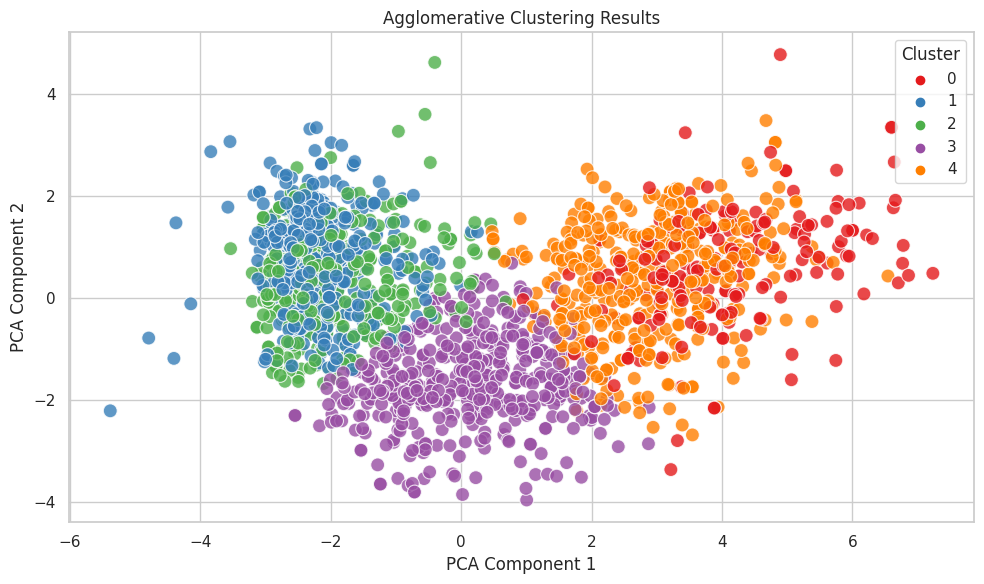

In [70]:
cluster_labels = cluster_pipeline.named_steps['cluster'].labels_
df_pca = cluster_pipeline.named_steps['dimentionality_reduction'].transform(df_train)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=cluster_labels, palette='Set1', s=100, alpha=0.8)
plt.title('Agglomerative Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.savefig('../report/plots/Agglomerative Clustering Results.jpg')
plt.show()

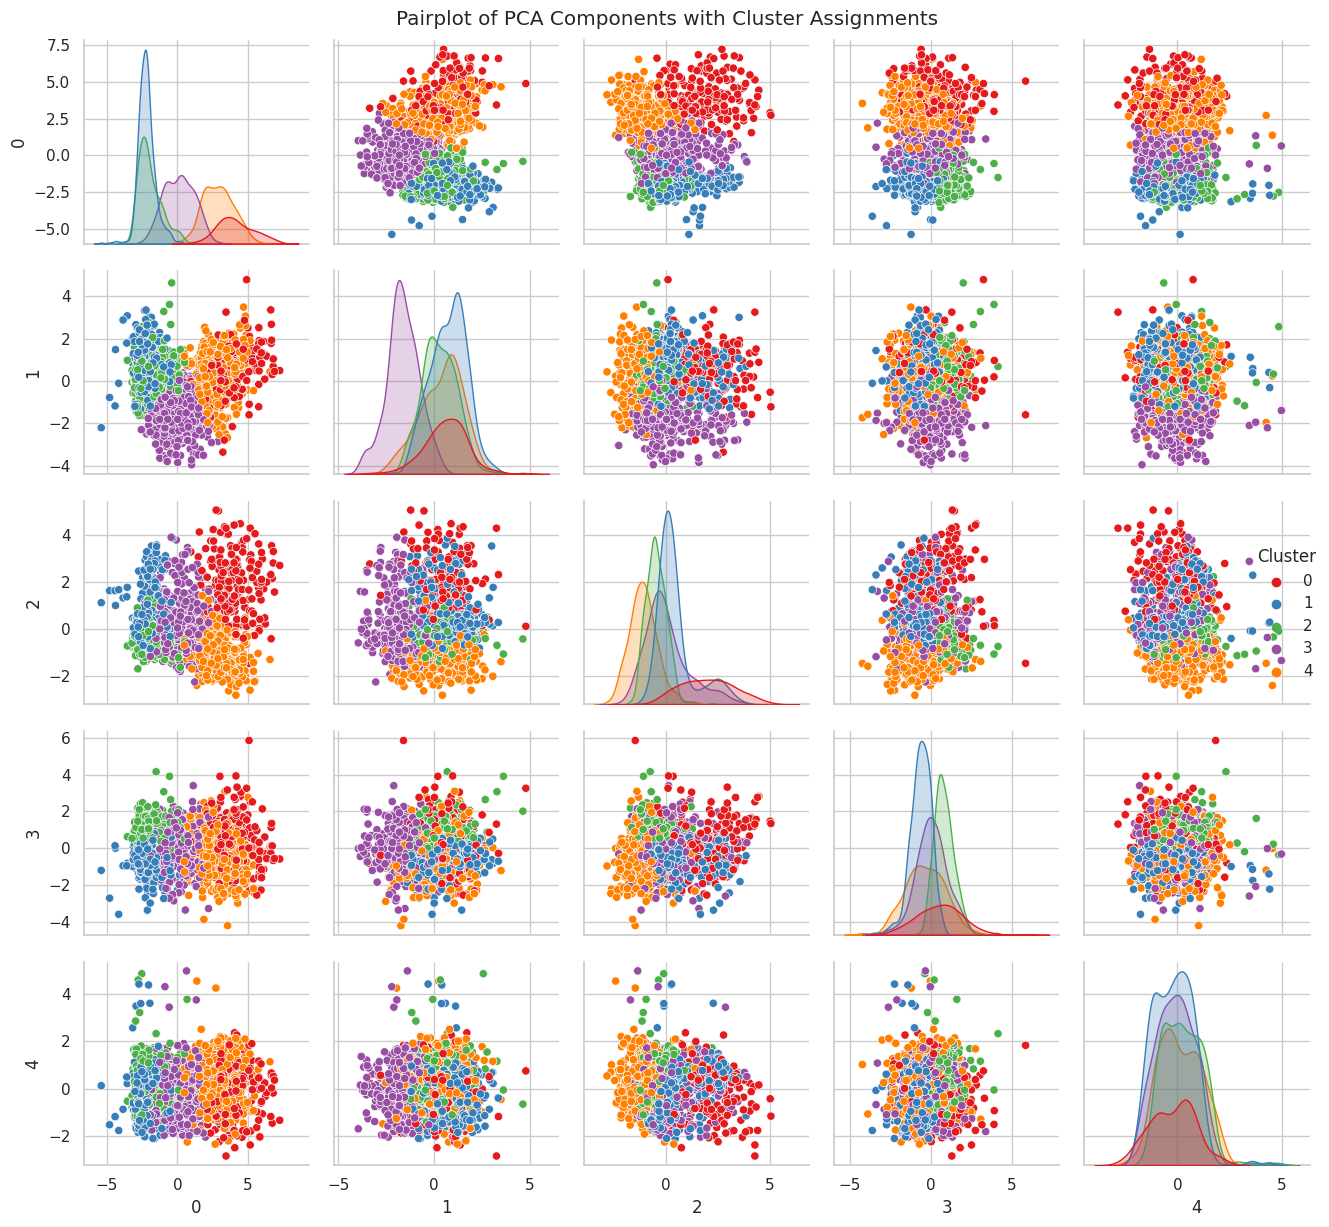

In [71]:
# Transform your training data using PCA
X_pca = cluster_pipeline.named_steps['dimentionality_reduction'].transform(df_train)

# Add cluster labels to the transformed data
X_pca_with_clusters = pd.DataFrame(X_pca.copy())
clusters_label = cluster_pipeline.named_steps['cluster'].labels_

X_pca_with_clusters['Cluster'] = clusters_label

# Create a pairplot of PCA components with cluster assignments as hue
sns.pairplot(data=X_pca_with_clusters, hue='Cluster', palette='Set1')
plt.suptitle('Pairplot of PCA Components with Cluster Assignments')
plt.tight_layout()
plt.savefig('../report/plots/Pairplot of PCA Components with Cluster Assignments.jpg')
plt.show()

## Evaluating Clusters

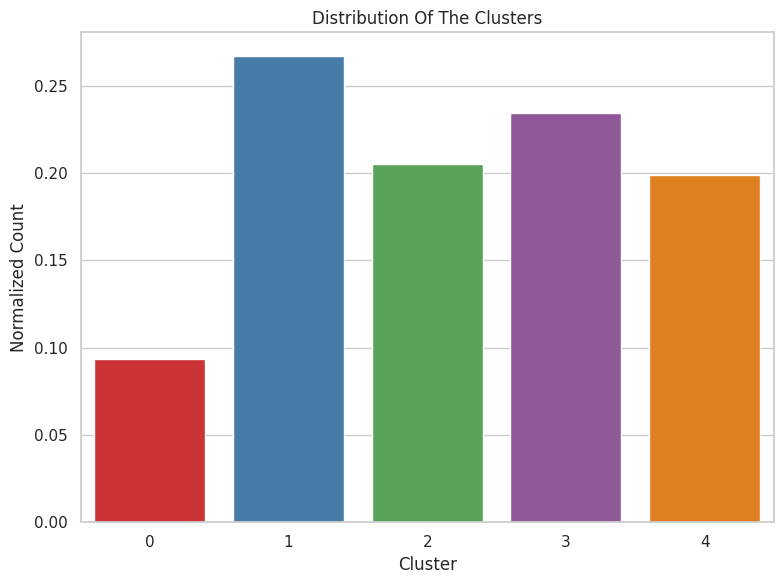

In [72]:
# Calculate the value counts of each cluster
cluster_counts = yhat_train["Clusters"].value_counts(normalize=True).reset_index()

# Rename columns for clarity
cluster_counts.columns = ["Cluster", "Normalized_Count"]

# Create the countplot
plt.figure(figsize=(8, 6))
pl = sns.barplot(x="Cluster", y="Normalized_Count", data=cluster_counts, palette="Set1")
plt.xlabel("Cluster")
plt.ylabel("Normalized Count")
plt.title("Distribution Of The Clusters")
plt.tight_layout()
plt.savefig('../report/plots/Distribution Of The Clusters.jpg')
plt.show()

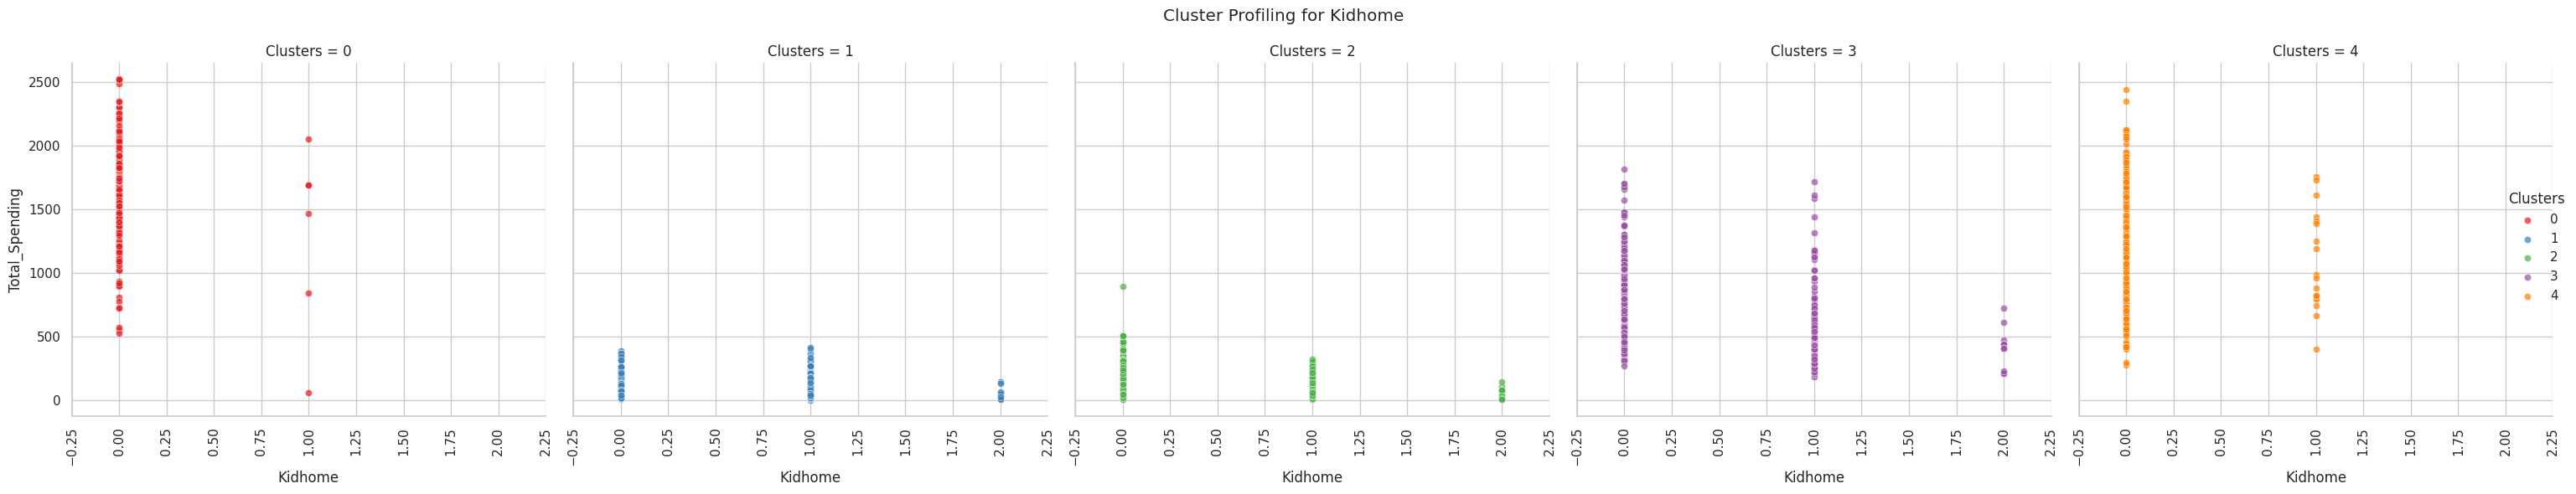

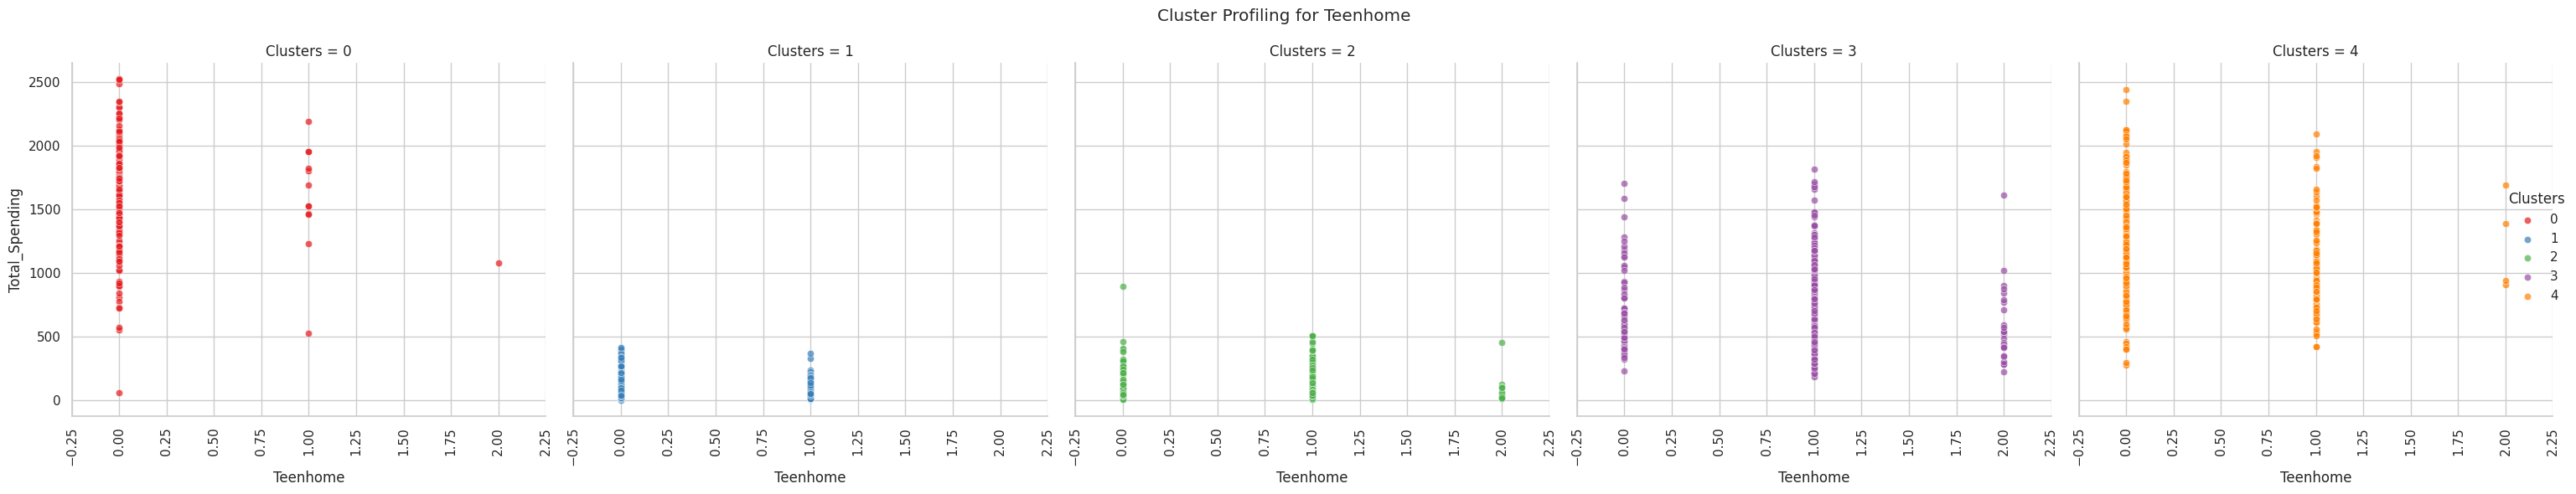

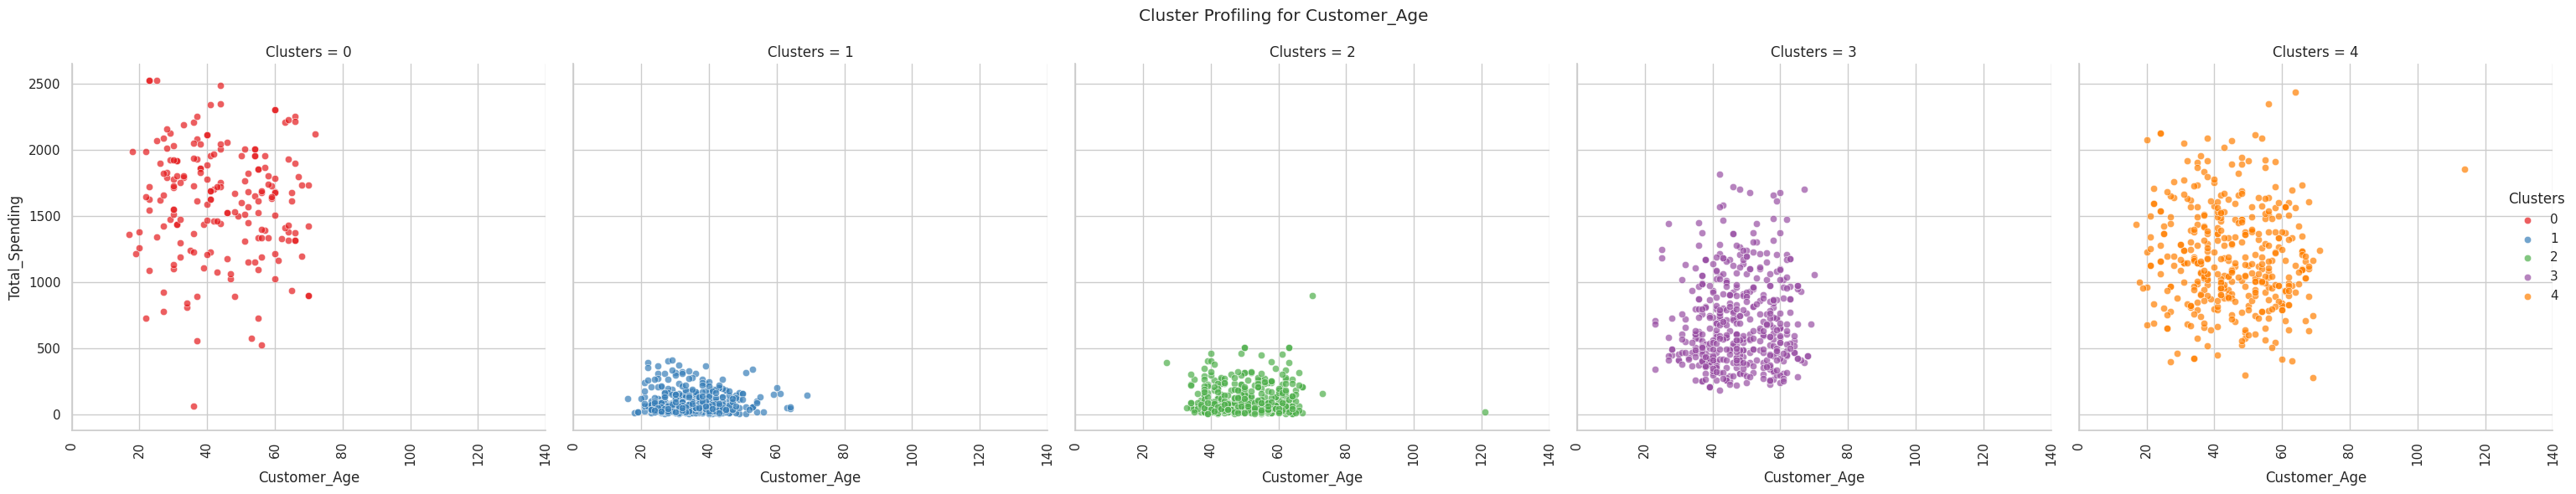

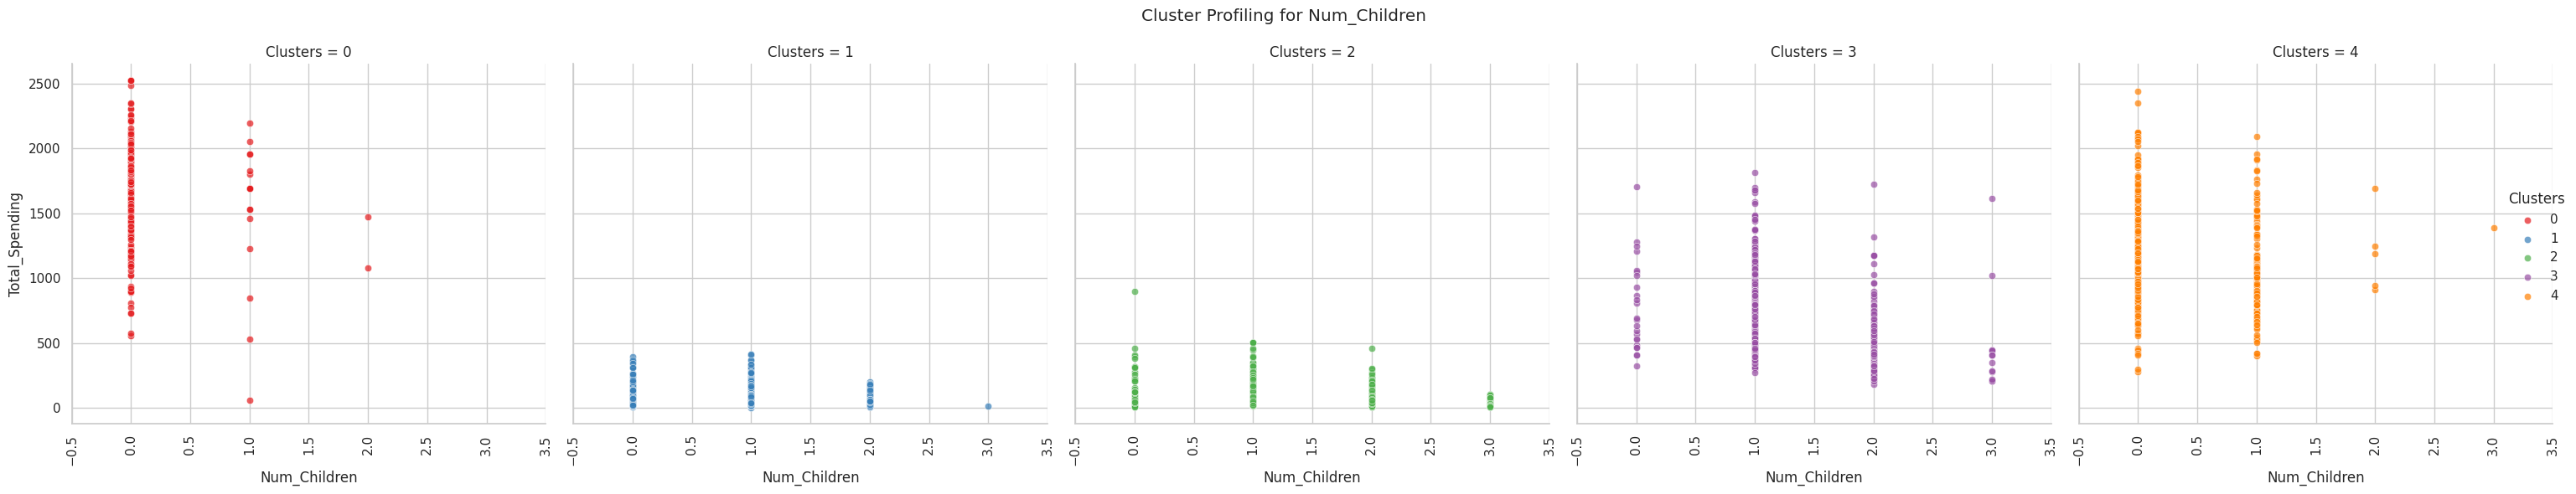

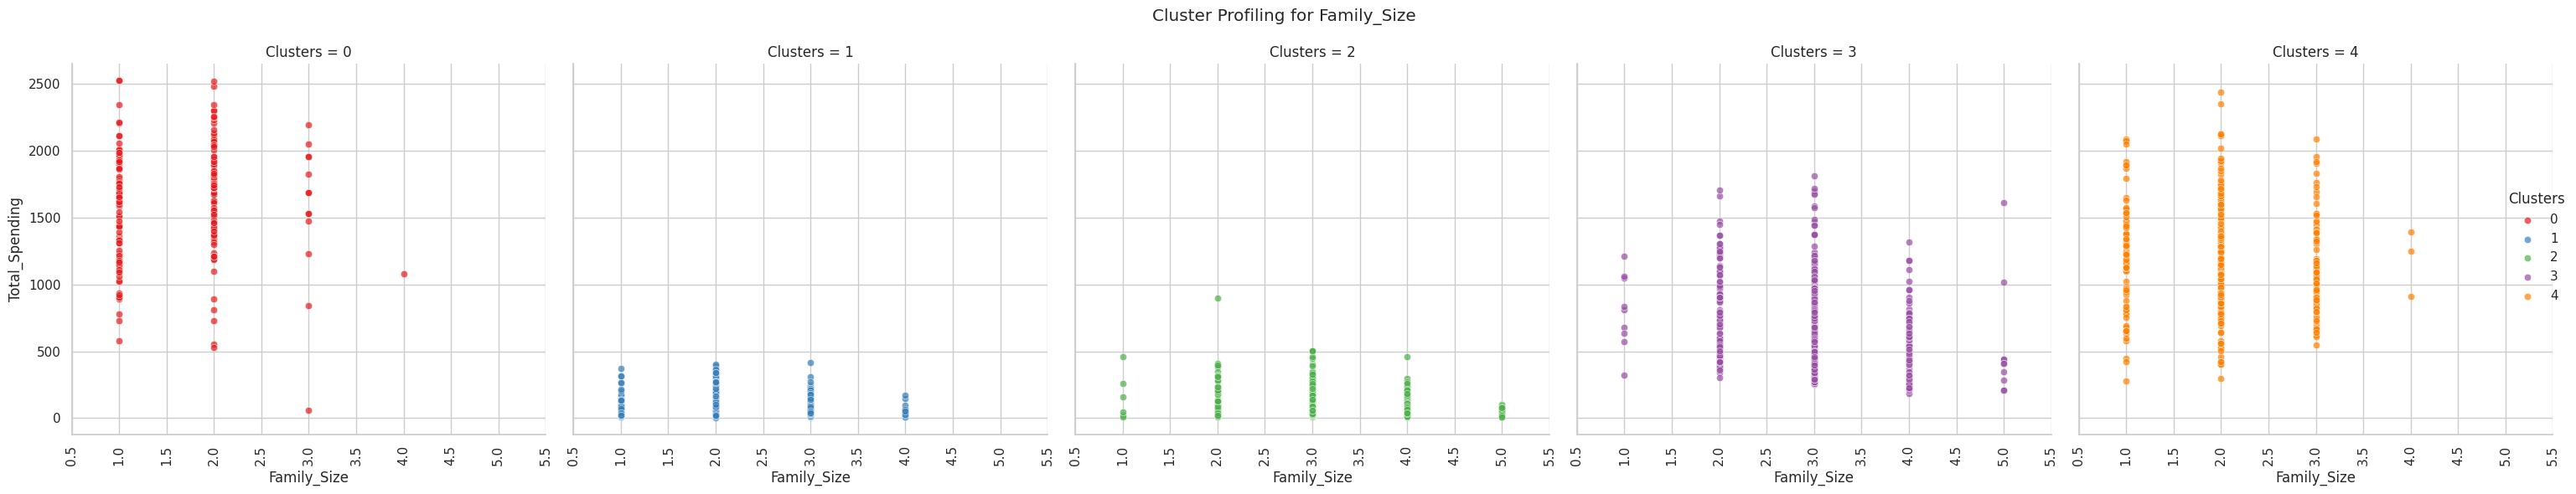

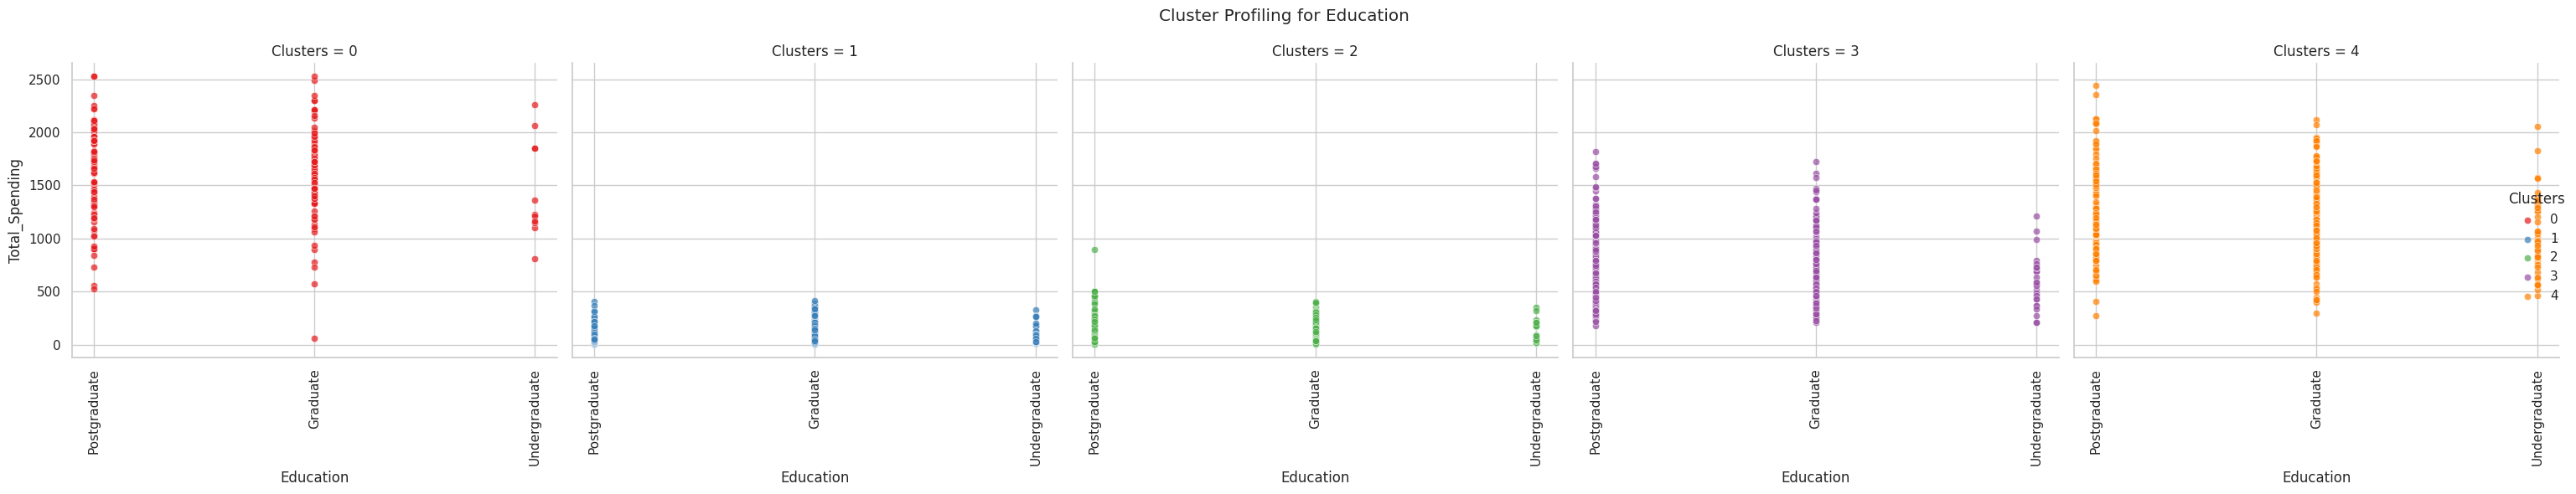

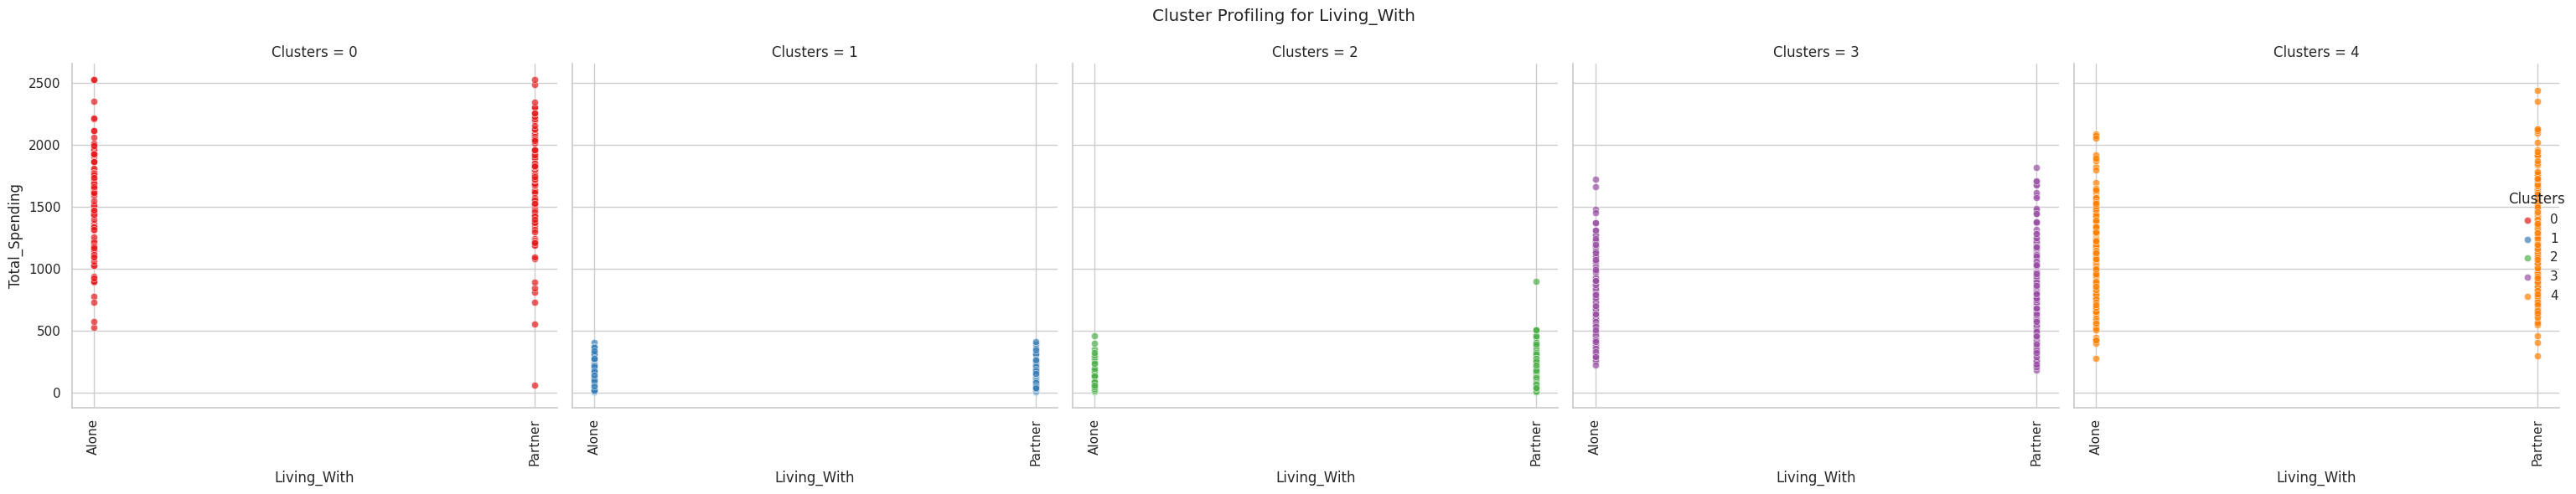

In [73]:
# List of columns representing spending on different product categories
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

Personal = [ "Kidhome", "Teenhome", "Customer_Age", "Num_Children", "Family_Size", "Education","Living_With"]

for i in Personal:
    g = sns.FacetGrid(yhat_train, col="Clusters", hue="Clusters", palette="Set1", height=6)
    g.map(sns.scatterplot, i, "Total_Spending", alpha=0.7)
    g.add_legend()
    g.set_xticklabels(rotation=90)
    plt.subplots_adjust(top=0.85)  # Optional: Adjust the plot title position
    g.fig.suptitle(f"Cluster Profiling for {i}")
    plt.tight_layout()
    plt.savefig(f'../report/plots/Cluster Profiling for {i}.jpg')
    plt.show()
